### Throughput

In [1]:
import os
import glob
import pandas as pd
os.chdir("csv")

Соединим все тесты в одном файле

In [46]:
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [47]:
all_filenames

['Throghput-jmh-result-thread-1.csv',
 'Throghput-jmh-result-thread-16.csv',
 'Throghput-jmh-result-thread-2.csv',
 'Throghput-jmh-result-thread-3.csv',
 'Throghput-jmh-result-thread-32.csv',
 'Throghput-jmh-result-thread-4.csv',
 'Throghput-jmh-result-thread-8.csv']

In [48]:
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

In [49]:
data = pd.read_csv("combined_csv.csv"); 

In [50]:
data.head()

,Benchmark,Mode,Threads,Samples,Score,Tail0,ScoreError,Tail1,Unit
0,com.sbt.concurrent.CounterBenchmark.Concurrent...,thrpt,2,10,153083517,18884,7931207,48413,ops/s
1,com.sbt.concurrent.CounterBenchmark.Concurrent...,thrpt,2,10,81154356,866811,2086180,268541,ops/s
2,com.sbt.concurrent.CounterBenchmark.Concurrent...,thrpt,2,10,71929160,152073,6455846,437746,ops/s
3,com.sbt.concurrent.CounterBenchmark.LockCounter,thrpt,2,10,15652758,53964,1902092,260969,ops/s
4,com.sbt.concurrent.CounterBenchmark.LockCounte...,thrpt,2,10,5887899,645807,1217305,906130,ops/s


Удалим название пакета из названий бенчмарков

In [51]:
def f(x):
    return x[len('com.sbt.concurrent.CounterBenchmark.'):]

In [52]:
data['Benchmark'] = data['Benchmark'].apply(f)

In [65]:
data.head()

,Benchmark,Mode,Threads,Samples,Score,Tail0,ScoreError,Tail1,Unit
0,ConcurrentCounter,thrpt,2,10,153083517,18884,7931207,48413,ops/s
1,ConcurrentCounter:getValueConcurrentCounter,thrpt,2,10,81154356,866811,2086180,268541,ops/s
2,ConcurrentCounter:incrementConcurrentCounter,thrpt,2,10,71929160,152073,6455846,437746,ops/s
3,LockCounter,thrpt,2,10,15652758,53964,1902092,260969,ops/s
4,LockCounter:getValueLockCounter,thrpt,2,10,5887899,645807,1217305,906130,ops/s


In [54]:
df = pd.DataFrame(data)

Построим график зависимости производительности от числа потоков

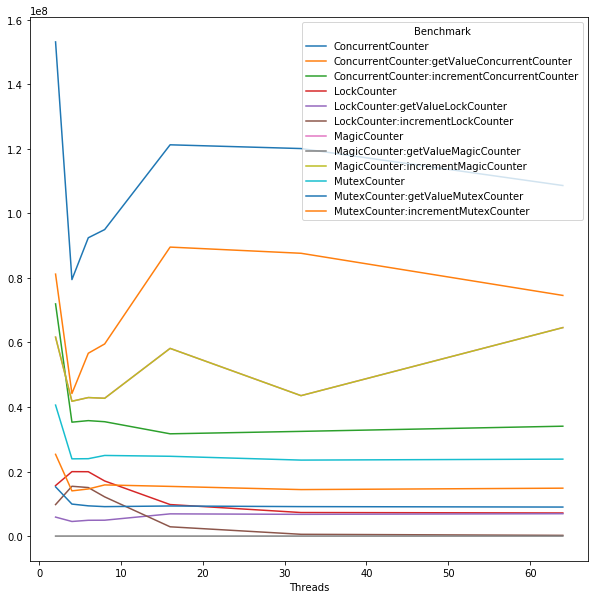

In [55]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
df.groupby(['Threads','Benchmark']).sum()['Score'].unstack().plot(ax=ax)
plt.show()

Рассмотрим отдельно getValue()

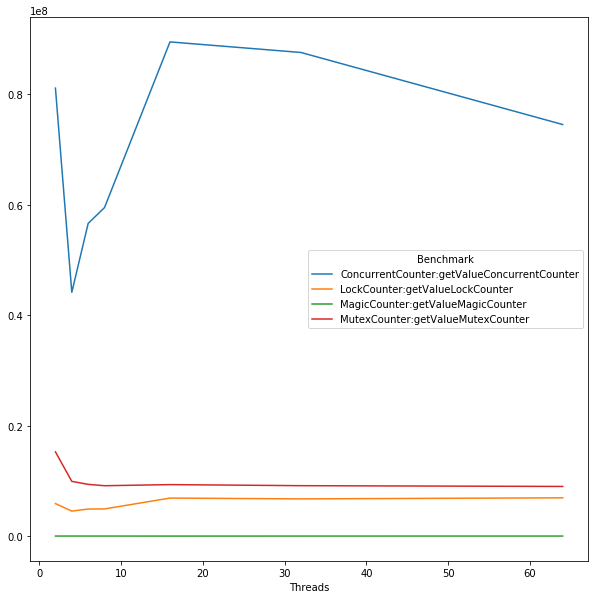

In [56]:
df = pd.DataFrame(data)
fig, ax = plt.subplots(figsize=(10,10))
get_array = ['ConcurrentCounter:getValueConcurrentCounter', 'LockCounter:getValueLockCounter', 'MagicCounter:getValueMagicCounter', 'MutexCounter:getValueMutexCounter']
df_general_get = df[df['Benchmark'].isin(get_array)]
df_general_get.groupby(['Threads','Benchmark']).sum()['Score'].unstack().plot(ax=ax)
plt.show()

На getValue() лучше всех атомик. Magic имеет наихудшую производительность, сказывается проход по массиву для сбора всех значений.

И increment()

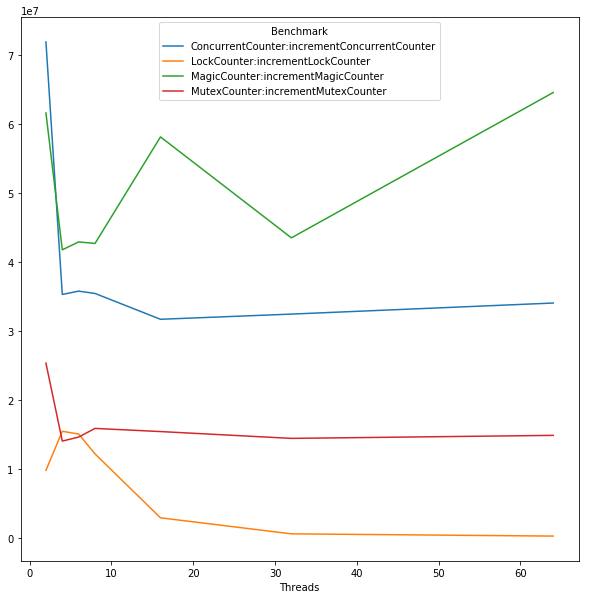

In [57]:
df = pd.DataFrame(data)
fig, ax = plt.subplots(figsize=(10,10))
increment_array = ['ConcurrentCounter:incrementConcurrentCounter', 'LockCounter:incrementLockCounter', 'MagicCounter:incrementMagicCounter', 'MutexCounter:incrementMutexCounter']
df_general_increment = df[df['Benchmark'].isin(increment_array)]
df_general_increment.groupby(['Threads','Benchmark']).sum()['Score'].unstack().plot(ax=ax)
plt.show()

Производительность инкремента с количеством потоков не особо меняется, после 16 потоков: потоки ждут освобождения секции (кроме Magic, у каждого потока своя ячейка). Лучше всех Magic, потому что нет локов. Потом Concurrent, что логично. Самый медленный лок. 

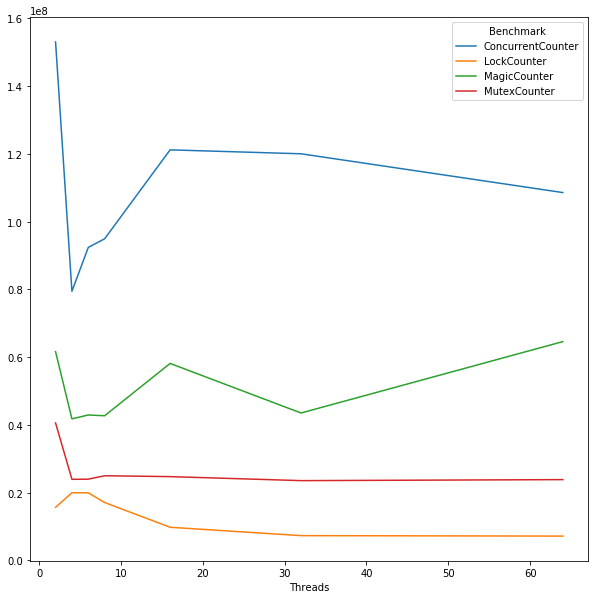

In [58]:
fig, ax = plt.subplots(figsize=(10,10))
array = ['ConcurrentCounter', 'LockCounter', 'MagicCounter', 'MutexCounter']
df_general = df[df['Benchmark'].isin(array)]
df_general.groupby(['Threads','Benchmark']).sum()['Score'].unstack().plot(ax=ax)
plt.show()

Как видим, ConcurrentCounter на атомиках имеет лучшую производительность. MagicCounter - тратит свою производительность на проход по массиву, чтобы посчитать все значения, но не тратит на локи, так как у каждого потока своя ячейка. Поэтому лучше мьютекса и лока.

В табличном виде

In [59]:
df.groupby(['Threads', 'Benchmark']).sum()['Score'].unstack()

Benchmark,ConcurrentCounter,ConcurrentCounter:getValueConcurrentCounter,ConcurrentCounter:incrementConcurrentCounter,LockCounter,LockCounter:getValueLockCounter,LockCounter:incrementLockCounter,MagicCounter,MagicCounter:getValueMagicCounter,MagicCounter:incrementMagicCounter,MutexCounter,MutexCounter:getValueMutexCounter,MutexCounter:incrementMutexCounter
Threads,,,,,,,,,,,,
2,153083517,81154356,71929160,15652758,5887899,9764858,61625805,7816,61617989,40583056,15256523,25326532
4,79458007,44165747,35292260,19965159,4528509,15436650,41779411,12171,41767240,23932381,9919740,14012640
6,92411875,56641778,35770097,19942523,4901749,15040773,42925423,10122,42915301,23977057,9374566,14602490
8,94952578,59518640,35433938,17077046,4923966,12153079,42698479,10045,42688434,24982533,9128044,15854489
16,121210159,89522738,31687421,9771292,6889438,2881853,58150491,3092,58147399,24725203,9328656,15396547
32,120049528,87610346,32439182,7299842,6742188,557654,43512540,8024,43504515,23543295,9135839,14407455
64,108599628,74556061,34043566,7167152,6935831,231321,64593946,10600,64583346,23841797,8996383,14845413


### Latency

Отобразим результаты тестов задержки

In [60]:
data1 = pd.read_csv("Latency-jmh-result.csv"); 
data1.head()

,Benchmark,Mode,Threads,Samples,Score,Tail0,ScoreError,Tail1,Unit
0,com.sbt.concurrent.LatencyBenchmark.Concurrent...,thrpt,2,10,651904917,515170,15905716,676267,ops/s
1,com.sbt.concurrent.LatencyBenchmark.Concurrent...,thrpt,2,10,260833010,961539,13838778,115141,ops/s
2,com.sbt.concurrent.LatencyBenchmark.Concurrent...,thrpt,2,10,391071906,553631,9650577,619151,ops/s
3,com.sbt.concurrent.LatencyBenchmark.LockCounter,thrpt,2,10,368208583,274843,26409480,787807,ops/s
4,com.sbt.concurrent.LatencyBenchmark.LockCounte...,thrpt,2,10,114588178,409140,5079608,210062,ops/s


Уберем из названия бенчмарков название пакета

In [61]:
def f1(x):
    return x[len('com.sbt.concurrent.LatencyBenchmark.'):]

Получим итоговую таблицу

In [62]:
data1['Benchmark'] = data1['Benchmark'].apply(f1)
data1.drop(['Tail0', 'Tail1', 'Samples', 'Mode', 'ScoreError'], axis=1).sort_values(by=['Score'], ascending=False)

,Benchmark,Threads,Score,Unit
0,ConcurrentCounter,2,651904917,ops/s
9,MutexCounter,2,525089184,ops/s
6,MagicCounter,2,509647892,ops/s
7,MagicCounter:pingMagicCounter,2,508935539,ops/s
2,ConcurrentCounter:pongConcurrentCounter,2,391071906,ops/s
3,LockCounter,2,368208583,ops/s
10,MutexCounter:pingMutexCounter,2,272460938,ops/s
1,ConcurrentCounter:pingConcurrentCounter,2,260833010,ops/s
5,LockCounter:pongLockCounter,2,253620404,ops/s
11,MutexCounter:pongMutexCounter,2,252628245,ops/s


In [63]:
df = pd.DataFrame(data1)
df_general = df[df['Benchmark'].isin(array)]
df_general.drop(['Tail0', 'Tail1', 'Samples', 'Mode', 'ScoreError'], axis=1).sort_values(by=['Score'], ascending=False)

,Benchmark,Threads,Score,Unit
0,ConcurrentCounter,2,651904917,ops/s
9,MutexCounter,2,525089184,ops/s
6,MagicCounter,2,509647892,ops/s
3,LockCounter,2,368208583,ops/s


Лучше всех у Concurrent, что логично. Magic лучше Lock-а, потому что выигрывает за счет быстрого инкремента, и получения значения без лока, хотя и проходит весь массив.